# Dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.models import Word2Vec
import gensim.downloader as api
import time
import itertools
#from transformers import RobertaTokenizer, TFRobertaModel
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense,Embedding,SimpleRNN,LSTM,Dropout,Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

# Load data

In [2]:
#load dataset into dataframe
twitter_df1 = pd.read_csv('twitter_hate_speech_and_offensive_lang.csv')
twitter_df2 = pd.read_csv('Tweets.csv')

In [3]:
twitter_df1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
twitter_df2.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
#create a new column for tweet label and map class accordingly
twitter_df1['label'] = twitter_df1['class'].map({0:'hate_speech',1:'offensive_language',2:'neither'})
twitter_df1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,label
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [6]:
#reduce dataframe to only the needed columns: tweets, label
twitter_df1 = twitter_df1[['tweet','label']]
twitter_df1.head()

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [7]:
twitter_df2 = twitter_df2[['selected_text','sentiment']].rename(columns={'selected_text': 'tweet', 'sentiment': 'label'})
twitter_df2.head()

,tweet,label
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


---

# Data Cleaning and Preprocessing

In [8]:
# text cleaning function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower() #make lower case
    text = re.sub('\[.*?\]', ' ', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', ' ', text) #remove links
    text = re.sub('rt|cc', ' ', text) #remove rt and cc
    text = re.sub('@\S+', ' ', text) #remove mentions
    text = re.sub('#\S+', ' ', text) #remove hastags
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #remove punctuations
    text = re.sub('\n', ' ', text) #remove newlines
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\s+', ' ', text) #remove extra white spaces
    return text

In [9]:
#clean text by applying clean_text function to each row
twitter_df1['tweet_clean'] = twitter_df1['tweet'].apply(clean_text)
twitter_df1.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,as a woman you shouldn t complain about clean...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dats cold tyga dwn bad for cuffin dat hoe...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg you ever fuck a bitch and she sta to cry...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,s the shit you hear about me might be true or...


In [10]:
twitter_df2['tweet_clean'] = twitter_df2['tweet'].apply(clean_text)
twitter_df2.head()

,tweet,label,tweet_clean
0,"I`d have responded, if I were going",neutral,i d have responded if i were going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying me
3,leave me alone,negative,leave me alone
4,"Sons of ****,",negative,sons of


In [20]:
#function to remove stop words from text
stop_words = stopwords.words('english') #initialize stopwords object
stop_words = stop_words

def remove_stopwords(text):
    ''' Remove stop words from text'''
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [21]:
#clean text further by applying the remove_stopwords function  
twitter_df1['tweet_clean'] = twitter_df1['tweet_clean'].apply(remove_stopwords)
twitter_df1.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dats cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [22]:
twitter_df2['tweet_clean'] = twitter_df2['tweet_clean'].apply(remove_stopwords)
twitter_df2.head()

,tweet,label,tweet_clean
0,"I`d have responded, if I were going",neutral,responded going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying
3,leave me alone,negative,leave alone
4,"Sons of ****,",negative,sons


In [263]:
#stemming function defined
stemmer = SnowballStemmer("english") #initialize stemming object

def stemm_text(text):
    '''Reduce words to their stem in a text'''
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [66]:
[word for word in 'Reduce words to their stem in a text'.split(' ') if word not in stopwords.words('english') ]

['Reduce', 'words', 'stem', 'text']

In [23]:
#stemming function defined
lemmatizer=WordNetLemmatizer() #initialize lemmatizing object

def lemmatize_text(text):
    '''Reduce words to their base form in a text'''
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [24]:
#clean text further by applying the lemmatize_text function  
twitter_df1['tweet_clean'] = twitter_df1['tweet_clean'].apply(lemmatize_text)
twitter_df1.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [28]:
twitter_df2['tweet_clean'] = twitter_df2['tweet_clean'].apply(lemmatize_text)
twitter_df2.head()

,tweet,label,tweet_clean
0,"I`d have responded, if I were going",neutral,responded going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying
3,leave me alone,negative,leave alone
4,"Sons of ****,",negative,son


---

# Visualization

In [29]:
#distribution of label classes
balance_counts1= twitter_df1.groupby('label')['label'].agg('count').values
balance_counts1

array([ 1430,  4163, 19190], dtype=int64)

In [30]:
balance_counts2= twitter_df2.groupby('label')['label'].agg('count').values
balance_counts2

array([ 7781, 11118,  8582], dtype=int64)

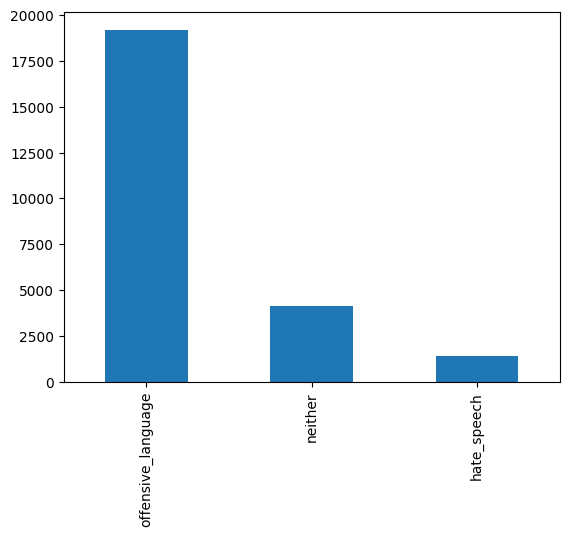

In [31]:
#plot distribution of label classes
twitter_df1['label'].value_counts().plot(kind='bar')
plt.show()

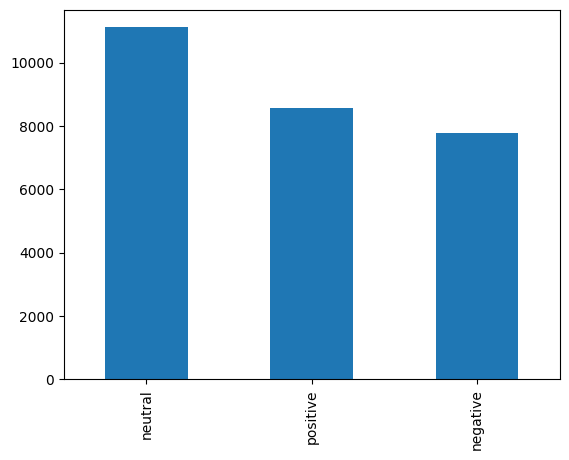

In [32]:
twitter_df2['label'].value_counts().plot(kind='bar')
plt.show()

In [33]:
#select non-offensive tweets by selecting only positive and neutral labels and shuffle
non_offensive_df = twitter_df2[(twitter_df2.label=='neutral')|(twitter_df2.label=='positive')].sample(frac=1).reset_index(drop=True)

non_offensive_df.head()

,tweet,label,tweet_clean
0,Goodnight and Goodbye ?,positive,goodnight goodbye
1,- I am THAT clueles,neutral,clueles
2,"Aw, Kaelah I feel so bad for you. This sounds ...",neutral,aw kaelah feel bad sound serious please get be...
3,good.,positive,good
4,aww that`s cute,positive,aww cute


In [34]:
non_offensive_df.shape

(19700, 3)

In [35]:
#concat tweet_df1 with non_offensive_df to balance labels
twitter_df = pd.concat([twitter_df1, non_offensive_df[:16457]], ignore_index=True, sort=False)
twitter_df.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [36]:
#rename labels accordingly
twitter_df.label=twitter_df.label.replace({'positive': 'not_offensive', 'neutral': 'not_offensive','offensive_language':'offensive','hate_speech':'not_offensive','neither':'not_offensive'})

In [37]:
twitter_df.label.unique()

array(['not_offensive', 'offensive'], dtype=object)

In [38]:
twitter_df.shape

(41240, 3)

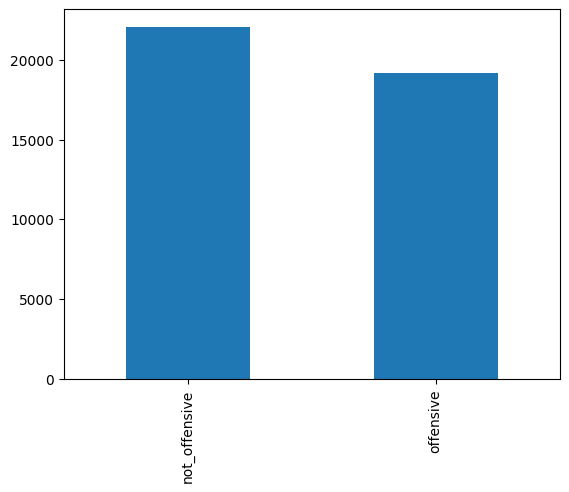

In [39]:
#plot distribution of label classes
twitter_df['label'].value_counts().plot(kind='bar')
plt.show()

In [40]:
#word cloud
twitter_mask = np.array(Image.open('twitter_mask3.jpg')) #fetch image for word cloud

#initialize word cloud object
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)

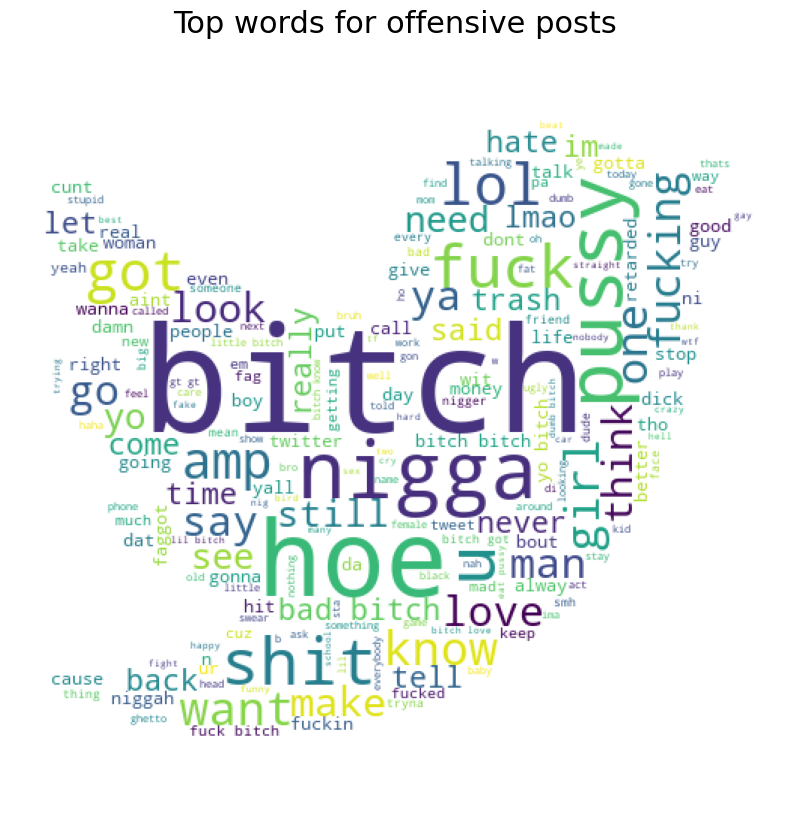

In [41]:
#visualize top words for offensive posts
wc.generate(' '.join(text for text in twitter_df.loc[twitter_df['label'] == 'offensive', 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for offensive posts', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

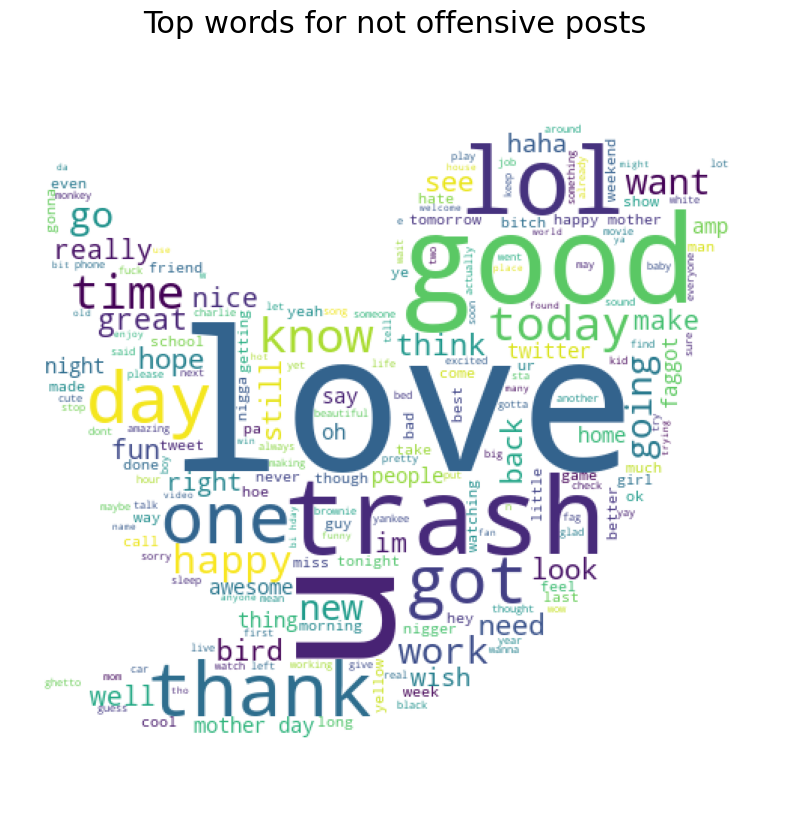

In [42]:
#visualize top words for not offensive posts
wc.generate(' '.join(text for text in twitter_df.loc[twitter_df['label'] != 'offensive', 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for not offensive posts', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [43]:
le=LabelEncoder()
twitter_df.label=le.fit_transform(twitter_df.label)
twitter_df

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,shit hear might true might faker bitch told ya
...,...,...,...
41235,Wish,0,wish
41236,eating chicken noodle soup...... its one of th...,0,eating chicken noodle soup one day
41237,", like your new pix!",0,like new pix
41238,deadlines!,0,deadline


In [44]:
le.classes_

array(['not_offensive', 'offensive'], dtype=object)

---

# Word Embeddings (word2vec)

In [45]:
#word tokenization: split tweets into smaller units (words)
word_tokens = [word_tokenize(row) for row in twitter_df['tweet_clean']]
word_tokens[:3]

[['woman',
  'complain',
  'cleaning',
  'house',
  'amp',
  'man',
  'always',
  'take',
  'trash'],
 ['boy', 'dat', 'cold', 'tyga', 'dwn', 'bad', 'cuffin', 'dat', 'hoe', 'place'],
 ['dawg', 'ever', 'fuck', 'bitch', 'sta', 'cry', 'confused', 'shit']]

In [46]:
# define word2vec parameters
size = 200 #number of dimensions of the embeddings and the default is 100. default is 100
window = 3 #maximum distance between a target word and words around the target word. default is 5
min_count = 1 #minimum count of words to consider when training the model. default is 1
workers = 3 #number of partitions during training. default workers is 3
sg = 1 #training algorithm, either CBOW(0) or skip gram(1). default is 1
word2vec_model = 'word2vec_' + str(size) + '.model' #model filename

In [47]:
start_time = time.time()
# Train the Word2Vec Model on corpus
w2v_model = Word2Vec(word_tokens,
                     min_count = min_count,
                     vector_size = size,
                     workers = workers,
                     window = window,
                     sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model)

Time taken to train word2vec model: 5.231616497039795


In [48]:
# Load the model from the model file
w2v_model = Word2Vec.load(word2vec_model)

In [282]:
# Unique ID of the word
print("Index of the word 'woman':")
print(w2v_model.wv.key_to_index["woman"])

Index of the word 'woman':
135


In [139]:
#get the embedding of word: woman
w2v_model.wv.get_vector('woman')

array([-0.03311276, -0.10411036, -0.05422262,  0.10690127,  0.19428457,
       -0.12563702,  0.24330372,  0.4006307 , -0.01182623, -0.05767914,
       -0.07566147, -0.19019885, -0.05636643,  0.1766129 , -0.22395414,
       -0.02952043,  0.18169841,  0.12551567, -0.11925479, -0.48075885,
        0.18831776, -0.19143586,  0.06966726,  0.03344977,  0.21596332,
       -0.16685478, -0.04269205,  0.00662752, -0.24788281,  0.25477862,
        0.1079548 ,  0.048678  ,  0.18847415, -0.03781334, -0.20920035,
        0.04968992,  0.05218754, -0.29937956, -0.0485103 , -0.20054434,
       -0.22524981, -0.02852645, -0.01968171, -0.0711638 ,  0.3315888 ,
       -0.03886743, -0.18810031, -0.25270927,  0.20322162,  0.19901447,
        0.07973369, -0.20561364,  0.0029085 , -0.20884308,  0.21816078,
       -0.1511736 ,  0.0910345 , -0.23651542, -0.12697545,  0.03530165,
       -0.06291594, -0.14452834,  0.18501681, -0.03062542, -0.37553227,
        0.25145003, -0.02384233,  0.48601368, -0.3426845 ,  0.28

In [50]:
#sample similar words: bitch
w2v_model.wv.similar_by_word("bitch")

[('hoe', 0.9273132681846619),
 ('nigga', 0.886177122592926),
 ('ni', 0.8794847726821899),
 ('niggah', 0.8748619556427002),
 ('faggot', 0.8686574697494507),
 ('em', 0.851855993270874),
 ('fuck', 0.8433228731155396),
 ('nigger', 0.8402727246284485),
 ('cause', 0.8385131359100342),
 ('fag', 0.8277724385261536)]

In [51]:
#sample similar words: happy
w2v_model.wv.similar_by_word("love")

[('made', 0.9732946753501892),
 ('booty', 0.9578907489776611),
 ('thanks', 0.9573215842247009),
 ('thank', 0.9571657776832581),
 ('called', 0.9543210864067078),
 ('calling', 0.9522069096565247),
 ('beautiful', 0.9516103863716125),
 ('world', 0.9515858292579651),
 ('sick', 0.9506458640098572),
 ('main', 0.9498938918113708)]

In [52]:
# Total number of the words 
print(len(w2v_model.wv.key_to_index))

22622


In [53]:
# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(w2v_model.wv['bitch']))

Length of the vector generated for a word
200


In [54]:
# total numberof extracted words.
vocab=w2v_model.wv.key_to_index
print("The total number of words are : ",len(vocab))

The total number of words are :  22622


In [55]:
# print(vocab)
vocab=list(vocab.keys())
vocab[:12]

['bitch',
 'hoe',
 'like',
 'pussy',
 'get',
 'got',
 'nigga',
 'u',
 'as',
 'lol',
 'love',
 'good']

In [56]:
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  22622


In [181]:
word_vec_dict['bitch']

array([-0.16788208, -0.07457134,  0.26056883,  0.24156357, -0.10354778,
       -0.15627152,  0.26406989,  0.40793633, -0.10006687, -0.31677482,
       -0.07634593, -0.09848217, -0.11926055,  0.33470878, -0.37440097,
        0.00636435,  0.28656316,  0.10178446, -0.19850492, -0.59327966,
        0.21213144,  0.08036336,  0.24500415,  0.14698589,  0.20926401,
       -0.1007277 ,  0.04366324,  0.10652409, -0.31380245,  0.12426118,
       -0.05510568, -0.11383644,  0.25206915, -0.1503791 , -0.26386967,
       -0.01623379,  0.04396221, -0.19597045, -0.09408162, -0.3307025 ,
       -0.2589585 ,  0.09639338, -0.32443935, -0.00176719,  0.2362179 ,
        0.02332477, -0.33309063, -0.07546431,  0.06198529,  0.2625876 ,
       -0.22172026, -0.24952169, -0.12095386, -0.06094551,  0.01986991,
       -0.1605791 ,  0.05097338, -0.310743  , -0.2341008 ,  0.04515078,
        0.05254075, -0.18537764,  0.11345509,  0.02684606, -0.17759967,
        0.40151247, -0.14294015,  0.34911433, -0.20951931,  0.31

In [58]:
# # just check
#for word in vocab[:1]:
#    print(word_vec_dict[word])

In [182]:
# Create an embedding_matrix with shape (vocab_size, embedding_dim)
size = 200
embedding_matrix_w2v = np.zeros((len(vocab), size))

# Fill in the embedding_matrix with the corresponding embeddings
for i, word in enumerate(vocab):
    if word in word_vec_dict:
        embedding_matrix_w2v[i] = word_vec_dict[word]
    else:
        # If the word is not in the GloVe embeddings file, use a random initialization
        embedding_matrix_w2v[i] = np.random.rand(size)

In [183]:
embedding_matrix_w2v

array([[-1.67882085e-01, -7.45713413e-02,  2.60568827e-01, ...,
        -4.13307369e-01, -4.12428737e-01, -6.04876988e-02],
       [-2.42107306e-02, -1.63423762e-01,  3.46614756e-02, ...,
        -3.78344804e-01, -3.89457315e-01, -1.30287185e-01],
       [-2.13886857e-01,  9.11971703e-02, -4.41226661e-02, ...,
        -3.60931009e-01, -7.34679997e-02, -1.99832335e-01],
       ...,
       [ 2.92357281e-02, -1.99378915e-02,  7.50588020e-03, ...,
        -4.37059142e-02, -1.72944628e-02, -3.62604507e-04],
       [ 1.35427704e-02, -1.56332217e-02,  2.86592916e-03, ...,
        -3.12081501e-02, -8.60387553e-03, -7.32687116e-03],
       [ 1.29989265e-02, -1.72038674e-02,  1.31155807e-03, ...,
        -3.99665795e-02, -1.83878411e-02, -7.33893830e-03]])

In [60]:
# Convert the text data into numerical sequences using Word2Vec
num_sequences_w2v = [] 

for row in twitter_df['tweet_clean']:
    num_sequence = []
    for word in row.split():
        if word in w2v_model.wv.key_to_index.keys():
            num_sequence.append(w2v_model.wv.key_to_index[word])
    num_sequences_w2v.append(num_sequence)

In [61]:
num_sequences_w2v[0]

[135, 1256, 938, 211, 21, 37, 92, 61, 18]

In [62]:
len(num_sequences)

41240

In [63]:
max_sequence_length = max(len(sequence) for sequence in num_sequences)  # max lenght of a tweet/text
max_sequence_length

28

In [65]:
# now padding to have a maximum length of 28
pad_tweets_w2v= pad_sequences(num_sequences, maxlen=max_sequence_length, padding='post')
pad_tweets_w2v.shape   # note that we had 41240 tweets and we have padded each review to have  a lenght of 28 words.

(41240, 28)

In [67]:
len(pad_tweets_w2v[0])

28

In [68]:
pad_tweets_w2v[0]

array([ 135, 1256,  938,  211,   21,   37,   92,   61,   18,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

# Word Embeddings (GloVe)

In [69]:
#load pretrained model
glove_model = api.load("glove-twitter-100")

[=================================================-] 99.7% 386.1/387.1MB downloaded

In [70]:
#save model
glove_model.save('glove_model')

In [ ]:
#load model
glove_model = gensim.models.KeyedVectors.load('glove_model')

In [140]:
# Unique ID of the word
print("Index of the word 'woman':")
print(glove_model.key_to_index["woman"])

Index of the word 'woman':
1240


In [141]:
#get the embedding of word: love
glove_model['woman']

array([ 0.35761  , -0.55737  , -0.29762  ,  0.56073  , -0.3983   ,
       -0.21551  ,  0.59801  ,  0.13016  ,  0.60363  , -0.4305   ,
       -0.3259   ,  0.096317 , -4.1119   , -0.27945  ,  0.21279  ,
        0.28401  ,  0.26991  , -0.65553  ,  0.48464  ,  0.18451  ,
        1.0443   , -0.069635 , -0.098869 , -0.016446 , -0.25633  ,
        0.55831  , -0.50894  , -0.16896  , -0.6802   ,  0.49299  ,
        0.83425  , -0.4249   , -0.16513  ,  0.66931  ,  0.38609  ,
        0.47012  , -0.026249 ,  0.19812  , -0.3473   ,  0.034589 ,
       -0.25654  ,  0.26041  ,  0.45436  ,  0.061987 ,  0.79604  ,
        0.3097   ,  0.61956  ,  0.50329  , -0.12585  , -0.0071808,
       -0.83839  ,  0.29762  , -0.35479  , -0.50594  , -0.16857  ,
        0.062532 , -0.31103  ,  0.086456 , -0.66457  ,  0.80991  ,
        0.037768 ,  0.70021  ,  0.26671  , -0.33556  ,  0.3361   ,
        0.16335  ,  0.048709 , -0.16753  ,  0.32006  ,  0.2376   ,
       -0.01335  , -0.73784  ,  0.33628  , -0.70988  ,  0.3347

In [144]:
#sample similar words: woman
glove_model.most_similar('woman')

[('women', 0.8050916194915771),
 ('girl', 0.7974741458892822),
 ('wife', 0.7853384017944336),
 ('mother', 0.7815033793449402),
 ('person', 0.7773492932319641),
 ('female', 0.7678147554397583),
 ('guy', 0.7642642259597778),
 ('she', 0.7594019174575806),
 ('daughter', 0.740329921245575),
 ('child', 0.736954927444458)]

In [168]:
# total numberof extracted words.
vocab_glove=glove_model.key_to_index
print("The total number of words are : ",len(vocab_glove))

The total number of words are :  1193514


In [169]:
glove_dict={}
for word in vocab_glove:
    glove_dict[word]=glove_model.get_vector(word)
print("The no of key-value pairs : ",len(glove_dict)) # should come equal to vocab size

The no of key-value pairs :  1193514


In [172]:
# Create an embedding_matrix with shape (vocab_size, embedding_dim)
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab_glove), embedding_dim))

# Fill in the embedding_matrix with the corresponding embeddings
for i, word in enumerate(vocab_glove):
    if word in glove_dict:
        embedding_matrix[i] = glove_dict[word]
    else:
        # If the word is not in the GloVe embeddings file, use a random initialization
        embedding_matrix[i] = np.random.rand(embedding_dim)

In [173]:
embedding_matrix

array([[ 0.63006002,  0.65177   ,  0.25545001, ...,  0.55096   ,
         0.64705998, -0.60930002],
       [ 0.18205   , -0.048483  ,  0.23965999, ..., -0.33579999,
         0.18884   , -0.40786001],
       [ 1.06739998,  0.45716   ,  0.51463002, ...,  0.13974001,
         0.76486999, -0.17314   ],
       ...,
       [ 0.28891999,  0.25407001,  0.11113   , ..., -0.61580002,
         0.046846  , -0.086387  ],
       [-0.38313001,  0.064609  ,  0.27384001, ..., -0.16395999,
        -0.26971   , -0.69941002],
       [-0.028777  , -0.72606999, -0.82770002, ..., -0.69694   ,
        -0.76516998, -1.09010005]])

In [145]:
# Convert the text data into numerical sequences using GloVe
num_sequences_glove = [] 

for row in twitter_df['tweet_clean']:
    num_sequence = []
    for word in row.split():
        if word in glove_model:
            num_sequence.append(glove_model.key_to_index[word])
    num_sequences_glove.append(num_sequence)

In [146]:
num_sequences_glove[0]

[1240, 5032, 5639, 543, 12800, 246, 245, 284, 6740]

In [147]:
len(num_sequences_glove)

41240

In [148]:
max(len(sequence) for sequence in num_sequences_glove)

28

In [149]:
# now padding to have a maximum length of 28
pad_tweets_glove= pad_sequences(num_sequences_glove, maxlen=max_sequence_length, padding='post')
pad_tweets_glove.shape   # note that we had 41240 tweets and we have padded each review to have  a lenght of 28 words.

(41240, 28)

In [150]:
pad_tweets_glove[0]

array([ 1240,  5032,  5639,   543, 12800,   246,   245,   284,  6740,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

---

# Model Building

In [151]:
# prepare train and val sets first
y=tf.keras.utils.to_categorical(twitter_df['label'])  # one hot target as required by neural network.
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [152]:
x_train1,x_test1,y_train1,y_test1=train_test_split(pad_tweets_w2v,y,test_size=0.20,random_state=42)

In [153]:
x_train2,x_test2,y_train2,y_test2=train_test_split(pad_tweets_glove,y,test_size=0.20,random_state=42)

In [164]:
# Define the hyperparameters
vocab_size_w2v = len(w2v_model.wv.key_to_index) # total no of words w2v
vocab_size_glove = len(glove_model.key_to_index) # total no of words glove
embed_dim_w2v=w2v_model.vector_size # embedding dimension as choosen in word2vec constructor
embed_dim_glove=glove_model.vector_size # embedding dimension as choosen in word2vec constructor
hidden_units = 64
num_classes = 2
learning_rate = 0.001
batch_size = 64
epochs = 20
steps_per_epoch=100

In [165]:
print(f'vocab size w2v:{vocab_size_w2v}')
print(f'vocab size glove:{vocab_size_glove}')
print(f'embed dim w2v:{embed_dim_w2v}')
print(f'embed dim glove:{embed_dim_glove}')
print(f'max sequence length:{max_sequence_length}')

vocab size w2v:22622
vocab size glove:1193514
embed dim w2v:200
embed dim glove:100
max sequence length:28


In [156]:
#Call back setup
mc = ModelCheckpoint(filepath='./base_model.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0.0001,
                   patience=5,
                   verbose=1)
cb = [mc,es]

## word2vec + LSTM

In [186]:
# define the model architecture :LSTM
lstm1 = Sequential()
lstm1.add(Embedding(input_dim=vocab_size_w2v, output_dim=embed_dim_w2v, weights=[embedding_matrix_w2v], input_length=max_sequence_length, trainable=False))
lstm1.add(LSTM(128, activation='relu'))
lstm1.add(Dense(units=hidden_units, activation='relu'))
lstm1.add(Dropout(0.3))
lstm1.add(Dense(units=num_classes, activation='softmax'))

lstm1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
lstm1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 28, 200)           4524400   
                                                                 
 lstm_14 (LSTM)              (None, 128)               168448    
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 2)                 130       
                                                                 
Total params: 4,701,234
Trainable params: 176,834
Non-trainable params: 4,524,400
_________________________________________________________________


In [187]:
# fitting the model.
lstm_hist1=lstm1.fit(x_train1,y_train1,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test1,y_test1))

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5228
Epoch 1: val_loss did not improve from 0.14382
100/100 [==============================] - 9s 74ms/step - loss: 0.6936 - accuracy: 0.5228 - val_loss: 0.6841 - val_accuracy: 0.5404
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.6204 - accuracy: 0.6725
Epoch 2: val_loss did not improve from 0.14382
100/100 [==============================] - 7s 72ms/step - loss: 0.6209 - accuracy: 0.6725 - val_loss: 0.5638 - val_accuracy: 0.7122
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.5137 - accuracy: 0.7672
Epoch 3: val_loss did not improve from 0.14382
100/100 [==============================] - 7s 74ms/step - loss: 0.5125 - accuracy: 0.7681 - val_loss: 0.4076 - val_accuracy: 0.8252
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8270
Epoch 4: val_loss did not improve from 0.14382
100/100 [=======================

In [188]:
os.rename('base_model.h5','lstm1.h5')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_model.h5' -> 'lstm1.h5'

## GloVe + LSTM

In [176]:
# Define the model architecture
lstm2 = Sequential()
lstm2.add(Embedding(input_dim=vocab_size_glove, output_dim=embed_dim_glove, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
lstm2.add(LSTM(units=128))
lstm2.add(Dense(units=hidden_units, activation='relu'))
lstm2.add(Dropout(0.3))
lstm2.add(Dense(units=num_classes, activation='softmax'))

lstm2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
lstm2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 28, 100)           119351400 
                                                                 
 lstm_11 (LSTM)              (None, 128)               117248    
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                                 
Total params: 119,477,034
Trainable params: 125,634
Non-trainable params: 119,351,400
_________________________________________________________________


In [177]:
# fitting the model.
lstm_hist2=lstm2.fit(x_train2,y_train2,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test2,y_test2))

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.7191
Epoch 1: val_loss did not improve from 0.26185
100/100 [==============================] - 12s 75ms/step - loss: 0.5388 - accuracy: 0.7191 - val_loss: 0.3138 - val_accuracy: 0.9054
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.9152
Epoch 2: val_loss improved from 0.26185 to 0.21761, saving model to .\base_model.h5
100/100 [==============================] - 9s 89ms/step - loss: 0.2671 - accuracy: 0.9152 - val_loss: 0.2176 - val_accuracy: 0.9248
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.2143 - accuracy: 0.9257
Epoch 3: val_loss improved from 0.21761 to 0.18947, saving model to .\base_model.h5
100/100 [==============================] - 10s 96ms/step - loss: 0.2131 - accuracy: 0.9262 - val_loss: 0.1895 - val_accuracy: 0.9283
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.9324
Epo

In [160]:
os.rename('base_model.h5','lstm2.h5')

(32992, 2)

## BERT + Dense layers

In [177]:
x_train3,x_test3,y_train3,y_test3=train_test_split(twitter_df['tweet_clean'],y,test_size=0.20,random_state=42)

In [178]:
# Bert layers
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
x = Dense(64, activation='relu')(outputs['pooled_output'])
x = Dropout(0.2, name="dropout1")(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2, name="dropout2")(x)
x = Dense(2, activation='softmax', name="output")(x)

# Use inputs and outputs to construct a final model
bert = tf.keras.Model(inputs=[text_input], outputs = [x])

bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
bert.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
# fitting the model
bert_hist=bert.fit(x_train3,y_train3,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test3,y_test3))

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.6275 
Epoch 1: val_loss did not improve from 0.25464
100/100 [==============================] - 36962s 373s/step - loss: 0.6304 - accuracy: 0.6275 - val_loss: 0.5266 - val_accuracy: 0.7288
Epoch 2/20
 47/100 [=============>................] - ETA: 44:48 - loss: 0.5235 - accuracy: 0.7443

In [ ]:
os.rename('base_model.h5','bert.h5')

---

# Performance Evaluation

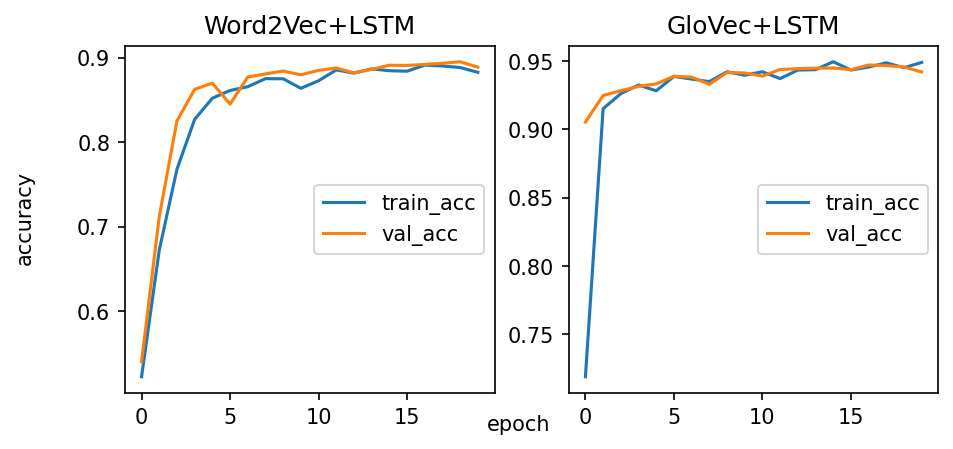

In [190]:
#plot train and validation accuracy across epochs
fig = plt.figure(dpi=150, figsize = (7,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(lstm_hist1.history['accuracy'], label='train_acc')
ax1.plot(lstm_hist1.history['val_accuracy'], label = 'val_acc')
ax1.legend(loc='center right')
ax2.plot(lstm_hist2.history['accuracy'], label='train_acc')
ax2.plot(lstm_hist2.history['val_accuracy'], label = 'val_acc')
ax2.legend(loc='center right')

fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
fig.text(0.03, 0.5, 'accuracy', ha='center', va='center', rotation='vertical')

ax1.set_title('Word2Vec+LSTM')
ax2.set_title('GloVec+LSTM')
plt.show()

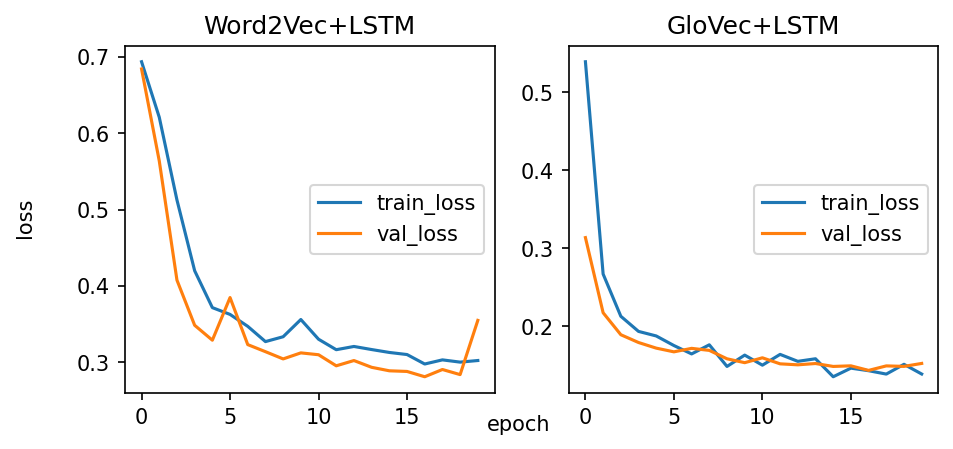

In [192]:
#plot train and validation loss across epochs
fig = plt.figure(dpi=150, figsize = (7,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(lstm_hist1.history['loss'], label='train_loss')
ax1.plot(lstm_hist1.history['val_loss'], label = 'val_loss')
ax1.legend(loc='center right')
ax2.plot(lstm_hist2.history['loss'], label='train_loss')
ax2.plot(lstm_hist2.history['val_loss'], label = 'val_loss')
ax2.legend(loc='center right')

fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
fig.text(0.03, 0.5, 'loss', ha='center', va='center', rotation='vertical')

ax1.set_title('Word2Vec+LSTM')
ax2.set_title('GloVec+LSTM')
plt.show()

In [193]:
#confusion matrix plot function 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `noramlize=True`
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without Normalized')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [197]:
labels = le.classes_

In [235]:
# model prediction: LSTM1
lstm1_pred = lstm1.predict(x=x_test1, verbose=0)
lstm1_pred = np.argmax(lstm1_pred, axis=1)

In [196]:
y_test_argmax =np.argmax(y_test1, axis=1)

In [204]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=lstm1_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.85      0.96      0.90      4434
    offensive       0.95      0.80      0.87      3814

     accuracy                           0.89      8248
    macro avg       0.90      0.88      0.89      8248
 weighted avg       0.90      0.89      0.89      8248



confusion matrix, without Normalized
[[4278  156]
 [ 762 3052]]


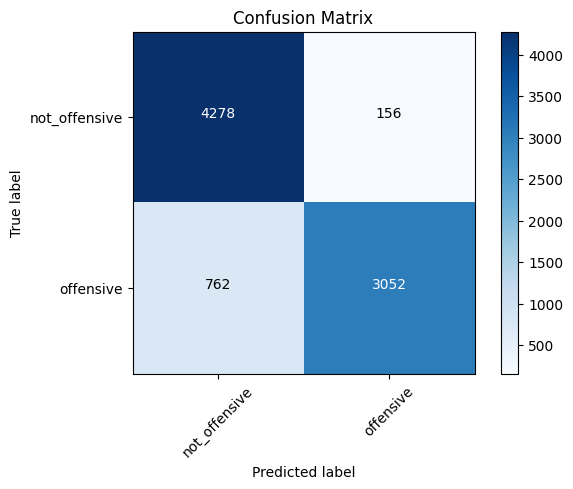

In [259]:
#confusion matrix
lstm1_cm =confusion_matrix(y_test_argmax, lstm1_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm1_cm, classes=labels)

---

In [250]:
# model prediction: LSTM2
lstm2_pred = lstm2.predict(x=x_test2, verbose=0)

#lstm2_pred = np.argmax(lstm2_pred, axis=1)

In [ ]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=lstm2_pred, target_names=labels))

In [ ]:
#confusion matrix
lstm2_cm =confusion_matrix(y_test_argmax, lstm2_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm2_cm, classes=labels)

----

# Testing

In [197]:
def preprocess_text(text):
    pass
def predict(vector):
    pass

In [284]:
def predict_post(text):
    
    cleaned_text = clean_text(text) #remove punctuations
    cleaned_text = remove_stopwords(cleaned_text) #remove stop words
    cleaned_text = lemmatize_text(cleaned_text) #stem words in text
    # Convert the text data into numerical sequences using Word2Vec
    vec_sequences = []
    for word in cleaned_text.split():
        if word in w2v_model.wv.key_to_index.keys():
            vec_sequences.append(w2v_model.wv.key_to_index[word])
    vec_sequences=[vec_sequences]
    
    padded_text= pad_sequences(vec_sequences, maxlen=max_sequence_length, padding='post') #pad text to fit neural network
    pred = lstm1.predict(padded_text, verbose=0) #run model to get prediction
    labels = le.classes_
    return labels[np.argmax(pred)],pred

In [285]:
text = 'happy'

In [286]:
predict_post(text)

('not_offensive', array([[0.97983575, 0.02016426]], dtype=float32))

In [287]:
text2 = 'That is good'

In [288]:
predict_post(text2)

('not_offensive', array([[0.9744348 , 0.02556523]], dtype=float32))

In [289]:
text3 ='faggot'

In [290]:
predict_post(text3)

('not_offensive', array([[0.5686999, 0.4313001]], dtype=float32))

In [291]:
predict_post('stop acting like a fool')

('not_offensive', array([[0.52052975, 0.47947022]], dtype=float32))

In [292]:
predict_post('bitch')

('not_offensive', array([[0.7589877 , 0.24101228]], dtype=float32))